In [4]:
#cpl 26-6-2020
#sound measurement with a phone calibrated with class-1 equipment

from __future__ import division
from scipy.io import loadmat
from scipy import signal
from scipy.signal import zpk2tf, zpk2sos, freqs, sosfilt #for waveform_analysis?
import numpy as np
from numpy import pi, log10 #for waveform_analysis?
import pandas as pd
from waveform_analysis.weighting_filters import A_weight
# source: https://github.com/endolith/waveform_analysis
import matplotlib.pyplot as plt
#plt.style.use('ggplot'
plt.style.use('tableau-colorblind10')

# Matlab files from various conditions are located in ../data/*.mat
# filenames and conditions can be found in ../data_phone/filelist.csv

def rms(signal):
    return np.sqrt(np.mean(np.square(signal)))

def load_calibration(file,plot=False):
    calib = loadmat(file) # load calibration file; this should correspond to 93.7 dB SPL
    s = calib['RZ6_mic'].flatten() # signal in [Volt]
    t = np.arange(len(s))/Fs
    
    #% reference pressure for the calibration signal
    pref = 10**((94-0.3)/20); 
    
    # root-mean-square Voltage of signal 
    p = rms(s)
    scaling = pref/p; # important scaling factor; any signal can be converted to dB SPL by this factor
    
    if plot==True:
        fig = plt.figure(figsize=(7,5))
        ax = fig.add_subplot(111)
        plt.plot(t,scaling*s)
        plt.xlabel('time [s]')
        plt.ylabel('sound pressure (Pa)')
    
    return scaling, s, t


def load_data(file,scaling):
    #load datafile and apply scaling to dB SPL
    sig = loadmat(file) 
    sd = scaling * sig['RZ6_mic'].flatten()
    t = np.arange(len(sd))/Fs
    # convert from dB SPL to A-weighted signal 
    # source: https://github.com/endolith/waveform_analysis
    sd_A = A_weight(sd,Fs)
    return t, sd, sd_A


def plot_spectrum(Fs, signal_dBSPL, signal_dBA):
    #plot spectrum of a signal (both dB SPL/dBA)
    nfft = 4096
    type_filter = 'flattop'
    # see https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#spectral-analysis
    # scaling{ ‘density’, ‘spectrum’ }, optional
    fA, Pper_specA = signal.periodogram(signal_dBA, Fs, type_filter, scaling='density', nfft=nfft)
    f, Pper_spec = signal.periodogram(signal_dBSPL, Fs, type_filter, scaling='density', nfft=nfft)
    
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)
    plt.semilogy(fA, Pper_specA,lw=2,label='dBA')
    plt.semilogy(f, Pper_spec,lw=2,label='dB SPL')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD V**2/Hz')
    plt.xlim(0, 8000)
    plt.ylim(1e-5, 1e8)
    plt.legend()
    
    max_loc = np.argmax(Pper_specA)
    print('max frequency: ' + '%2.1f'%(f[max_loc]) + ' Hz')
    
    # annotate peak frequency
    annot = ax.annotate('Freq: %2.1f'%(f[max_loc]),xy=(f[max_loc],Pper_spec[max_loc]),\
                        xycoords='data',xytext=(50,50),textcoords='offset points',\
                        arrowprops=dict(arrowstyle="->"),ha='center',va='bottom')
      
    return #nothing for now

def get_level(signal_dBSPL, signal_dBA, window):
    # function to get the rms of a signal in a manual window for both dB SPL- and dBA-traces
    # needs rms function
    td = np.arange(len(signal_dBA))/Fs
    t_begin=window[0]
    t_end=window[1]
    ind = np.bitwise_and(td>t_begin, td<t_end)
    
    s_keep = signal_dBSPL[ind]
    s_keep_A = signal_dBA[ind]
    t_keep = td[ind]
    
    psum = rms(s_keep)
    Lsum = 20*np.log10(psum)

    psum =  rms(s_keep_A)
    La = 20*np.log10(psum)
    
    #calculate over window or not? For now over windowed-signal
    print('dB SPL: ' + '%2.1f'%(Lsum))
    print('dBA: ' + '%2.1f'%(La))
    return Lsum, La

def Leq(signal):
    #determine Leq over a specific signal; it converts the signal (dB) into intensity and averages over all samples, and 
    #converts the avg intensity to sound-pressure-level (dB)
    I_signal = 10**(signal/20.0)
    Isum = np.sum(I_signal)
    Np = I_signal.shape[0]
    Leq_signal = 20.0*np.log10(Isum/Np)
    return Leq_signal

def get_level_table(file, window_table, plot=False):
    #function to read a txt file from measurements of a phone and plot a trace and calculate the Leq value over a window
    
    cor_factor_phone = 121.6 #specific calibration factor for phone; all dB values are offset by this value
    
    d1 = pd.read_csv(file)
    d1['datetime'] =  pd.to_datetime(d1['yyyy-mm-dd_HH.MM.SS.FFF'], format='%Y-%m-%d_%H.%M.%S.%f')
    d1[' LAeq (dB) cor'] = d1[' LAeq (dB)'] + cor_factor_phone #offset
    if plot==True:
        fig = plt.figure(figsize=(7,5))
        ax = fig.add_subplot(111)
        plt.axvline(window_table[0],linewidth=1, color='g')
        plt.axvline(window_table[1],linewidth=1, color='g')
        plt.plot(d1[' LAeq (dB) cor'])
        plt.xlabel('time [s]')
        plt.ylabel('LAeq (dB)')
    
    sig = d1[' LAeq (dB) cor']
    #determine Leq over window
    LeqD1 = Leq(sig[window_table[0]:window_table[1]])
    #print data
    print('Leq[window] ' + '%2.1f'%(LeqD1))
    return LeqD1

../data/recording_freq1000_att0.mat
max frequency: 1001.4 Hz
dB SPL: 68.0
dBA: 68.0
../data_phone/soundlevel_2020-03-06_15.04.23.159.txt
Leq[window] 70.4


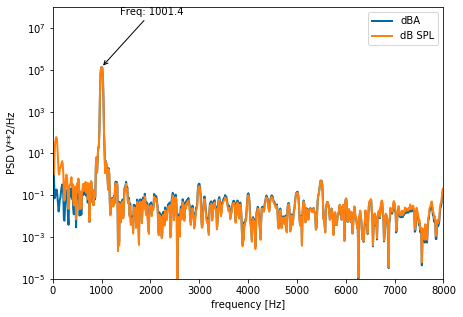

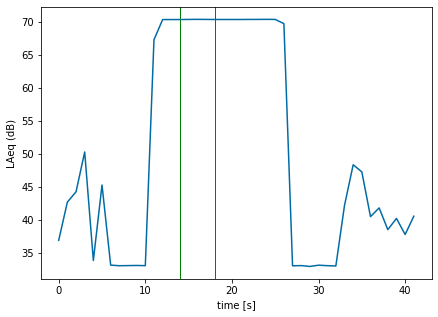

In [6]:
Fs = 48828.125 # sampling rate of TDT RZ6 system
file_calib = '../data/calibration.mat' # load calibration file; this should correspond to 93.7 dB SPL
scaling, s, t = load_calibration(file_calib)
#open filelist (txt file)
filelist = pd.read_csv('../data_phone/filelist.csv',delimiter=';')
#index = 0 for file on row 1 (zero-based)
window = [2,8]
#2k: 10-18
#4k: 15-25
#0.5k: 14-23
#0.25k: 14-23
window_table = [14,18]

#fig = plt.figure(figsize=(7,5))
#ax = fig.add_subplot(111)
#plt.plot(spl,spl_t,'ko-')
#ident = np.arange(30,80)
#plt.plot(ident,ident,'k:')
#plt.xlabel('Calibration dBA')
#plt.ylabel('Phone dBA')

# calculate levels, no-plot
spl = []
spl_t = []
# check filelist for actual files
# 1000Hz: range(0,6)
# 2000Hz: range(6,12)
# 4000Hz: range(12,18)
# 500Hz: range(18,24)
# 250Hz: range(24,30)

for index in range(0,1):
    #load matlab recording and convert it to dBA
    file = '../data/' + filelist.iloc[index,3]
    print(file)
    t, sd, sd_A = load_data(file,scaling)
    #plot spectrum of the (A-weighted) signal
    plot_spectrum(Fs, sd, sd_A)
    # calculate sound pressure level of A-weighted signal in a manual window
    Ls,La = get_level(sd,sd_A,window)
    
    #load recording from phone in the same condition
    file2 = '../data_phone/' + filelist.iloc[index,4]
    print(file2)
    # calculate mean sound pressure level of A-weighted signal measured in 1-s samples by the phone
    # in a manual window !check window by plots!
    La_table = get_level_table(file2,window_table,plot=True)
    #store all values and save the data
    spl.append(La)
    spl_t.append(La_table)

    



In [9]:
# calculate levels, no-plot
spl = []
spl_t = []
# check filelist for actual files
# 1000Hz: range(0,6)
# 2000Hz: range(6,12)
# 4000Hz: range(12,18)
# 500Hz: range(18,24)
# 250Hz: range(24,30)

for index in range(0,30):
    #load matlab recording and convert it to dBA
    file = '../data/' + filelist.iloc[index,3]
    #print(file)
    t, sd, sd_A = load_data(file,scaling)
    # plot spectrum of the (A-weighted) signal
    # plot_spectrum(Fs, sd, sd_A)
    # calculate sound pressure level of A-weighted signal in a manual window
    Ls,La = get_level(sd,sd_A,window)
    
    #load recording from phone in the same condition
    file2 = '../data_phone/' + filelist.iloc[index,4]
    #print(file2)
    # calculate mean sound pressure level of A-weighted signal measured in 1-s samples by the phone
    # in a manual window !check window by plots!
    La_table = get_level_table(file2,window_table)
    #store all values and save the data
    spl.append(La)
    spl_t.append(La_table)



dB SPL: 68.0
dBA: 68.0
Leq[window] 70.4
dB SPL: 58.0
dBA: 58.0
Leq[window] 60.4
dB SPL: 48.5
dBA: 48.0
Leq[window] 50.5
dB SPL: 39.8
dBA: 38.2
Leq[window] 41.7
dB SPL: 36.6
dBA: 29.3
Leq[window] 35.3
dB SPL: 35.2
dBA: 24.2
Leq[window] 33.3
dB SPL: 76.5
dBA: 77.8
Leq[window] 76.4
dB SPL: 66.5
dBA: 67.7
Leq[window] 66.5
dB SPL: 56.9
dBA: 58.1
Leq[window] 56.6
dB SPL: 47.2
dBA: 48.2
Leq[window] 47.1
dB SPL: 38.8
dBA: 38.3
Leq[window] 38.8
dB SPL: 35.0
dBA: 29.2
Leq[window] 33.9
dB SPL: 73.1
dBA: 74.1
Leq[window] 65.8
dB SPL: 63.4
dBA: 64.3
Leq[window] 53.8
dB SPL: 53.5
dBA: 54.4
Leq[window] 44.7
dB SPL: 43.9
dBA: 44.4
Leq[window] 36.5
dB SPL: 36.7
dBA: 34.7
Leq[window] 33.5
dB SPL: 34.2
dBA: 27.2
Leq[window] 33.1
dB SPL: 75.3
dBA: 72.1
Leq[window] 64.9
dB SPL: 65.5
dBA: 62.2
Leq[window] 55.1
dB SPL: 55.6
dBA: 52.4
Leq[window] 45.5
dB SPL: 45.9
dBA: 42.5
Leq[window] 37.7
dB SPL: 38.0
dBA: 32.9
Leq[window] 33.8
dB SPL: 34.2
dBA: 25.7
Leq[window] 33.1
dB SPL: 71.2
dBA: 62.5
Leq[window] 60.1


250
5.311498118055846
500
6.164521612752027
1000
4.988052180541631
2000
2.204296193612934
4000
7.8517074655542025


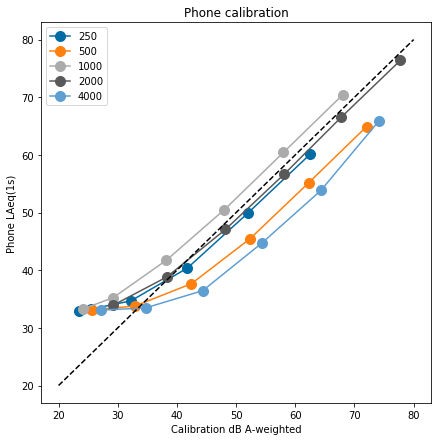

In [10]:
filelist = pd.read_csv('../data_phone/filelist.csv',delimiter=';')
res_df = pd.DataFrame({'dBA calibration':spl,'dBA phone':spl_t})
#combine results
res = pd.concat([filelist,res_df],axis=1)
res
fig, ax = plt.subplots(figsize=(7,7))
for key, grp in res.groupby(['f']):
    ax.plot(grp['dBA calibration'], grp['dBA phone'],'o-',ms=10, label=key)
    rms_diff = np.sqrt(np.mean(np.square(grp['dBA calibration']-grp['dBA phone'])))
    print(key)
    print(rms_diff)
    
plt.plot([20,80],[20,80],'k--')
plt.xlabel('Calibration dB A-weighted')
plt.ylabel('Phone LAeq(1s)')
plt.title('Phone calibration')
ax.legend()
plt.show()

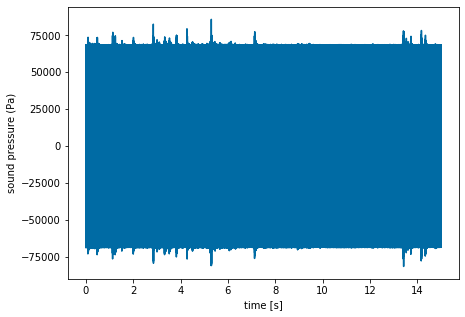

In [11]:
#example to load calibration file
scaling, s, t = load_calibration(file_calib,plot=True)

Leq[window] 60.4


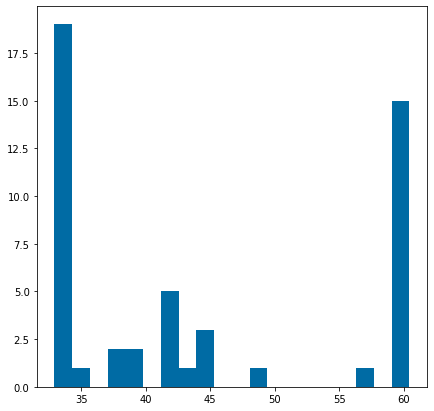

In [12]:
#example to load txt file and convert data and time colum
#see e.g. #https://stackabuse.com/converting-strings-to-datetime-in-python/

#file2='../data_phone/soundlevel_2020-03-06_15.12.04.833.txt'
#file2='../data_phone/soundlevel_2020-03-06_15.13.23.039.txt'
#d1 = pd.read_csv('../data_phone/soundlevel_2020-03-06_15.13.23.039.txt') 

file2='../data_phone/soundlevel_2020-03-06_15.02.46.856.txt'
date_col = ['yyyy-mm-dd_HH.MM.SS.FFF']
d1 = pd.read_csv(file2, parse_dates=date_col) 
#print(d1.dtypes)

cor_factor_phone = 121.6
d1[' LAeq (dB) cor'] = d1[' LAeq (dB)'] + cor_factor_phone 
sig = d1[' LAeq (dB) cor']

window_table=[21,31]
#print(window_table[0])
La_table = get_level_table(file2,window_table)
fig, ax = plt.subplots(figsize=(7,7))
plt.hist(sig,bins=20)

d1['datetime'] =  pd.to_datetime(d1['yyyy-mm-dd_HH.MM.SS.FFF'], format='%Y-%m-%d_%H.%M.%S.%f')
#d1

In [575]:
#https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#spectral-analysis
f, Pper_spec = signal.periodogram(s, Fs, 'flattop', scaling='spectrum', nfft=4096)
sA = A_weight(s,Fs)

../data/recording_freq250_att200.mat
max frequency: 202.7 Hz


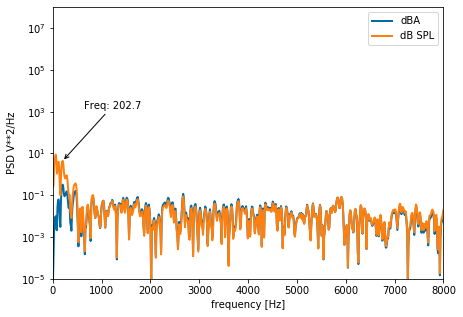

In [13]:
#background levels:
index = 30
file = '../data/' + filelist.iloc[index,3]
print(file)
t, sd, sd_A = load_data(file,scaling)
#plot spectrum of the (A-weighted) signal
plot_spectrum(Fs, sd, sd_A)

In [ ]:
#end